In [1]:
import torch
import torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from alibi_detect.utils.pytorch.kernels import DeepKernel, GaussianRBF
from alibi_detect.cd import SpotTheDiffDrift

np.random.seed(42)
torch.manual_seed(42)
%matplotlib inline

### Gaussian Corner

First example where reference data is Gaussian noise and test data is Gaussian noise but with the corner set to 1.

In [2]:
x_ref = np.random.normal(size=(1000, 1, 28, 28)).astype(np.float32)
x = np.random.normal(size=(1000, 1, 28, 28)).astype(np.float32)
x[:,0,:3,:3] = 1 * np.ones((1000,3,3)).astype(np.float32)

In [3]:
cd = SpotTheDiffDrift(
    x_ref,
    n_diffs=1,
    l1_reg=1e-3,
    backend='tensorflow',
    verbose=1,
    learning_rate=1e-1, 
    epochs=5, 
    batch_size=32,
)
preds = cd.predict(x)

46/46 [=] - 0s 7ms/step - loss_ma: 0.6931


In [4]:
print(f"Drift? {'Yes' if preds['data']['is_drift'] else 'No'}")
print(f"p-value: {preds['data']['p_val']}")

Drift? Yes
p-value: 1.0989913212802138e-62


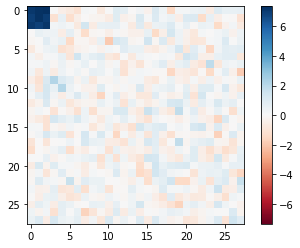

In [5]:
diff = preds['data']['diffs'][0,0]
plt.imshow(diff, cmap='RdBu', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.colorbar()

In [6]:
preds['data']['diff_coeffs']

array([1.5979948], dtype=float32)

By looking at the diff and noting that the coefficient > 0 we see that the detector was able to note that to make the average instance **more** like a test instance than a reference instance it should increase the values in the corner.

### Missing number

Now to consider a reference window of MNIST data and a test window without any zeros.

In [7]:
MNIST_PATH = '/home/oliver/Projects/alibi-detect/examples'
DOWNLOAD = False
MISSING_NUMBER = 0

mnist_train_ds = torchvision.datasets.MNIST(MNIST_PATH, train=True, download=DOWNLOAD)
train_x, train_y = mnist_train_ds.train_data, mnist_train_ds.train_labels

data = train_x[:, None, : , :].numpy().astype(np.float32)/255.
perm = np.random.permutation(np.arange(data.shape[0]))
x_ref = data[perm][:10000]
x = data[perm][10000:20000]
x_ref = x_ref[train_y[perm][:10000] != MISSING_NUMBER] 

In [8]:
cd = SpotTheDiffDrift(
    x_ref,
    n_diffs=1,
    l1_reg=1e-3,
    backend='pytorch',
    verbose=1,
    learning_rate=1e-2, 
    epochs=5, 
    batch_size=32,
)
preds = cd.predict(x)

No GPU detected, fall back on CPU.
Epoch 5/5: 100%|██████████| 446/446 [00:02<00:00, 202.73it/s, loss_ma=0.672]


In [9]:
print(f"Drift? {'Yes' if preds['data']['is_drift'] else 'No'}")
print(f"p-value: {preds['data']['p_val']}")
print(f"Diff coeffs: {preds['data']['diff_coeffs']}")

Drift? Yes
p-value: 3.2029491353676714e-09
Diff coeffs: [2.0126889]


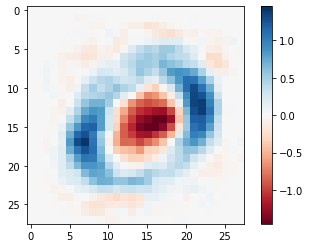

In [10]:
diff = preds['data']['diffs'][0,0]
plt.imshow(diff, cmap='RdBu', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
plt.colorbar()

We see that to differentiate reference from test instances the detector compared instances to a point that had below average values in the middle and above average values areas we expect a zero to be.